In [1]:
import os

In [2]:
data_path = os.path.join(os.getcwd(), "archive", "data", "data")
images_names = os.listdir(data_path)

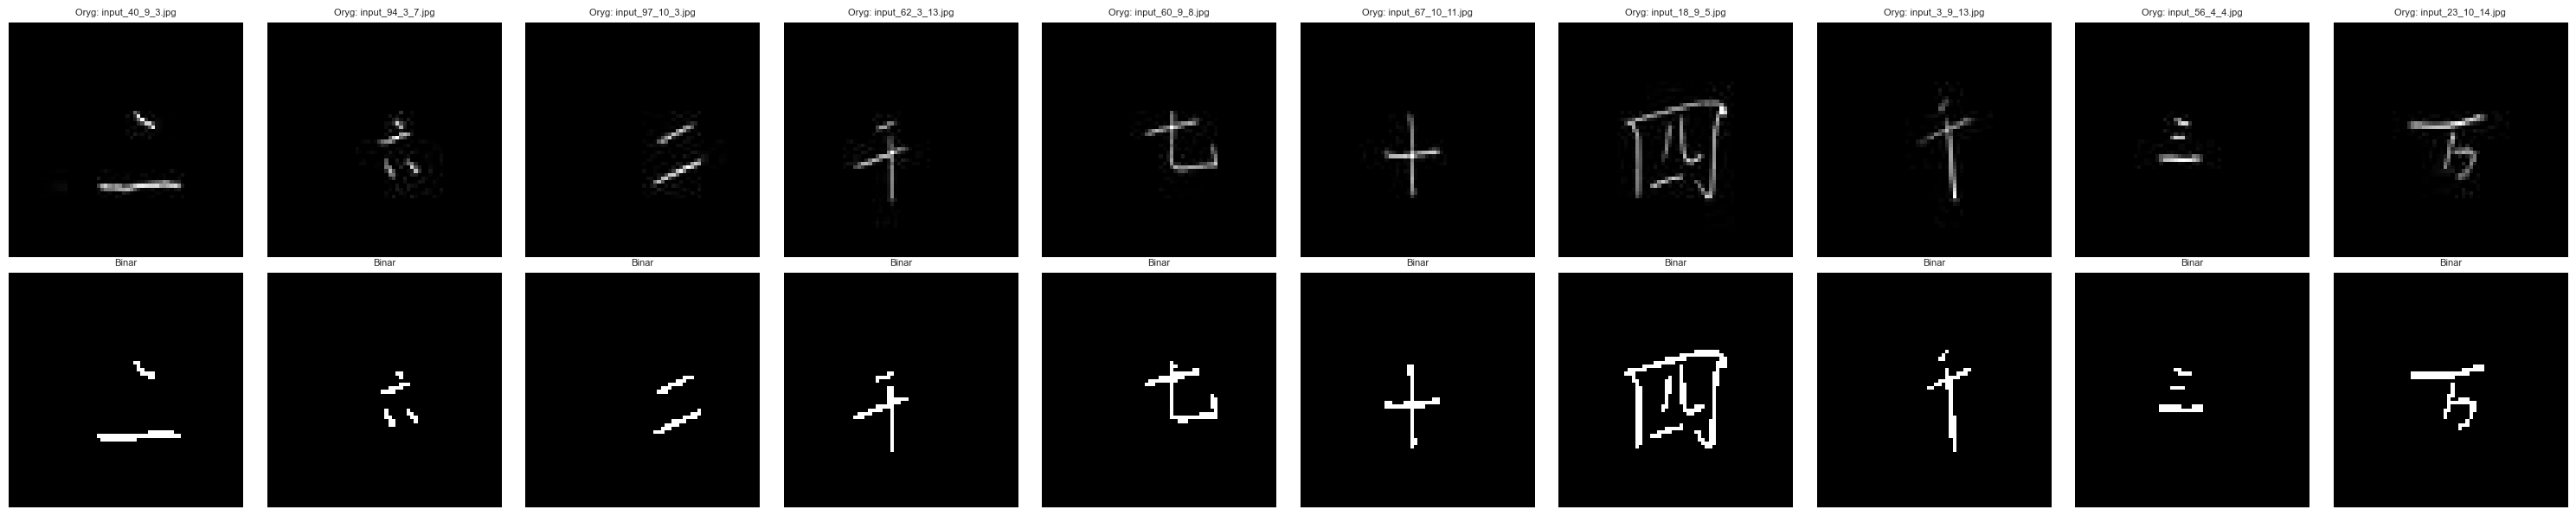

In [3]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def binarize_image(image: Image.Image, threshold: int = 20) -> Image.Image:
    grayscale = image.convert("L")
    binary = grayscale.point(lambda x: 255 if x > threshold else 0, mode='1')
    return binary

num_images = 10
threshold = 30

data_path = os.path.join(os.getcwd(), "archive", "data", "data")
images_names = os.listdir(data_path)
sample_images = random.sample(images_names, num_images)

plt.figure(figsize=(3 * num_images, 6))
for i, img_name in enumerate(sample_images):
    img_path = os.path.join(data_path, img_name)
    image = Image.open(img_path)
    bin_image = binarize_image(image.copy(), threshold)

    plt.subplot(2, num_images, i + 1)
    plt.imshow(image, cmap="gray")
    plt.title(f"Oryg: {img_name}", fontsize=8)
    plt.axis("off")

    plt.subplot(2, num_images, i + 1 + num_images)
    plt.imshow(bin_image, cmap="gray")
    plt.title(f"Binar", fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()



# Applying Markov-Chain denoising on one image

In [4]:
import ising
import importlib
importlib.reload(ising)
import numpy as np
import pandas as pd

In [5]:
def load_image(idx, data_path="archive/data/data", csv_path="archive/chinese_mnist.csv"):
    df = pd.read_csv(csv_path)
    if idx < 0 or idx >= len(df):
        raise IndexError(f"Index {idx} poza zakresem (0 - {len(df) - 1})")

    row = df.iloc[idx]
    suite_id = row['suite_id']
    sample_id = row['sample_id']
    code = row['code']

    filename = f"input_{suite_id}_{sample_id}_{code}.jpg"
    img_path = os.path.join(data_path, filename)

    image = Image.open(img_path)
    image = binarize_image(image)

    return image, row.to_dict()


Znak chiński: 九


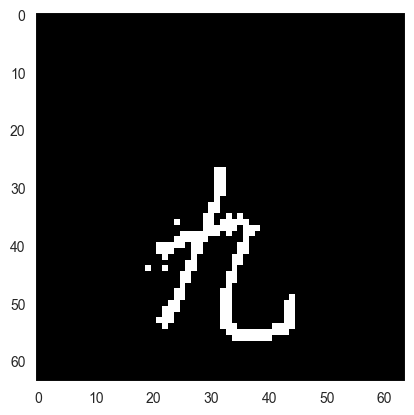

In [6]:
img, meta = load_image(0)
print("Znak chiński:", meta["character"])
plt.imshow(img, cmap="gray")
plt.grid(False)

In [7]:
def magnetize_image(image: np.ndarray) -> np.ndarray:
    if image.ndim == 3 and image.shape[2] == 1:
        image = image[:, :, 0]

    return 1 - 2 * image.astype(np.float64)

Znak chiński: 九 Values: (np.float64(-1.0), np.float64(1.0))


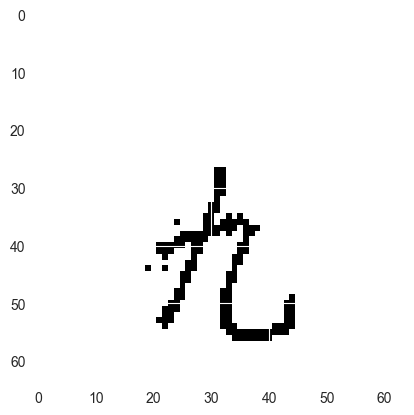

In [8]:
magnetized_img = magnetize_image(np.array(img))
print("Znak chiński:", meta["character"], "Values:", (magnetized_img.min(), magnetized_img.max()))
plt.imshow(magnetized_img, cmap="gray")

In [9]:
def add_flip_noise(image: np.ndarray, q: float = 0.9, show: bool = False) -> np.ndarray:
    if not np.all(np.isin(image, [-1, 1])):
        raise ValueError("Obraz musi zawierać tylko wartości -1 i 1.")

    noise = np.random.random(size=image.shape) > q  # True tam, gdzie odwracamy
    noisy = np.array(image, copy=True)
    noisy[noise] = -noisy[noise]

    if show:
        fig, axes = plt.subplots(figsize=(10, 6))
        axes.imshow(noisy, cmap=cm.gray, aspect="equal", interpolation="none", vmin=-1, vmax=1)
        axes.set_title(f"Obraz z szumem (q={q})")
        axes.axis("off")
        plt.show()

    return noisy

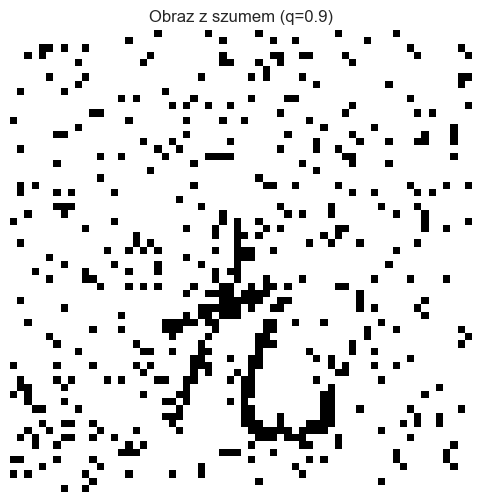

In [10]:
noisy = add_flip_noise(magnetized_img, q= 0.9, show=True)

In [11]:
def dice_score(pred: np.ndarray, target: np.ndarray) -> float:
    pred = pred.flatten()
    target = target.flatten()

    # Zamień -1 → 1, 1 → 0
    pred = (pred == -1).astype(np.uint8)
    target = (target == -1).astype(np.uint8)

    intersection = np.sum(pred & target)
    total = np.sum(pred) + np.sum(target)

    if total == 0:
        return 1.0  # Obie maski puste

    return 2.0 * intersection / total


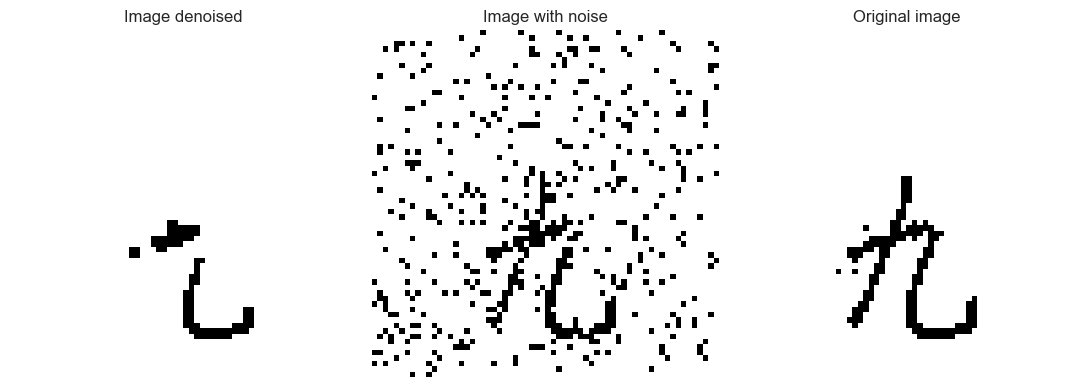

In [12]:
avg = ising.IsingDeNoise(noisy, 0.9)
avg[avg >= 0] = 1
avg[avg < 0] = -1


fig, axes = plt.subplots(ncols=3, figsize=(11, 6))
axes[0].imshow(avg, cmap=cm.gray, aspect="equal", interpolation="none", vmin=-1, vmax=1)
axes[0].set_title("Image denoised")
axes[1].imshow(noisy, cmap=cm.gray, aspect="equal", interpolation="none", vmin=-1, vmax=1)
axes[1].set_title("Image with noise")
axes[2].imshow(magnetized_img, cmap=cm.gray, aspect="equal", interpolation="none", vmin=-1, vmax=1)
axes[2].set_title("Original image")

for ax in axes:
    ax.axis("off")

plt.tight_layout()
plt.show()

In [13]:
dice_denoised = dice_score(avg, magnetized_img)
dice_noisy = dice_score(noisy, magnetized_img)

print(f"Dice score (denoised vs original): {dice_denoised:.4f}")
print(f"Dice score (noisy vs original):    {dice_noisy:.4f}")

Dice score (denoised vs original): 0.6862
Dice score (noisy vs original):    0.4096


# Noisiness vs DICE

## Small noisiness parameter in the chain

In [14]:
q_values = [0.5,0.75,0.9, 0.95]
csv_path = "archive/chinese_mnist.csv"
df_csv = pd.read_csv(csv_path)
total_images = len(df_csv)

num_images = 200
selected_indices = np.random.choice(total_images, size=num_images, replace=False)

In [15]:
import numpy as np
import pandas as pd
from tqdm import tqdm

results = []

for idx in tqdm(selected_indices, desc="Processing images"):
    image, info = load_image(idx)
    magnetized = magnetize_image(np.array(image))

    for q in q_values:
        noisy = add_flip_noise(magnetized, q=q, show=False)
        denoised = ising.IsingDeNoise(noisy, 0.9)
        denoised[denoised >= 0] = 1
        denoised[denoised < 0] = -1

        dice_denoised = dice_score(denoised, magnetized)
        dice_noisy = dice_score(noisy, magnetized)

        results.append({
            "image_value": info["value"],
            "image_character": info["character"],
            "suite_id": info['suite_id'],
            "sample_id": info['sample_id'],
            "code": info['code'],
            "q": q,
            "denoised_dice": dice_denoised,
            "noise_dice": dice_noisy
        })

df_results = pd.DataFrame(results)


Processing images: 100%|██████████| 200/200 [30:06<00:00,  9.03s/it]


In [16]:
df_results.to_csv("ising_denoising_results.csv", index=False)

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_dice_boxplots(df, highlight_q=0.9):
    df = df.copy()
    df["improvement"] = df["denoised_dice"] - df["noise_dice"]

    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

    sns.boxplot(data=df, x="q", y="denoised_dice", ax=axes[0])
    axes[0].set_title("Denoised Dice vs q")
    axes[0].set_xlabel("q")
    axes[0].set_ylabel("Dice score")
    axes[0].axvline(x=df["q"].sort_values().unique().tolist().index(highlight_q), color="red", linestyle="--")

    sns.boxplot(data=df, x="q", y="noise_dice", ax=axes[1])
    axes[1].set_title("Noisy Dice vs q")
    axes[1].set_xlabel("q")
    axes[1].set_ylabel("")
    axes[1].axvline(x=df["q"].sort_values().unique().tolist().index(highlight_q), color="red", linestyle="--")

    sns.boxplot(data=df, x="q", y="improvement", ax=axes[2])
    axes[2].set_title("Improvement (denoised - noisy) vs q")
    axes[2].set_xlabel("q")
    axes[2].set_ylabel("")
    axes[2].axvline(x=df["q"].sort_values().unique().tolist().index(highlight_q), color="red", linestyle="--")

    plt.tight_layout()
    plt.show()

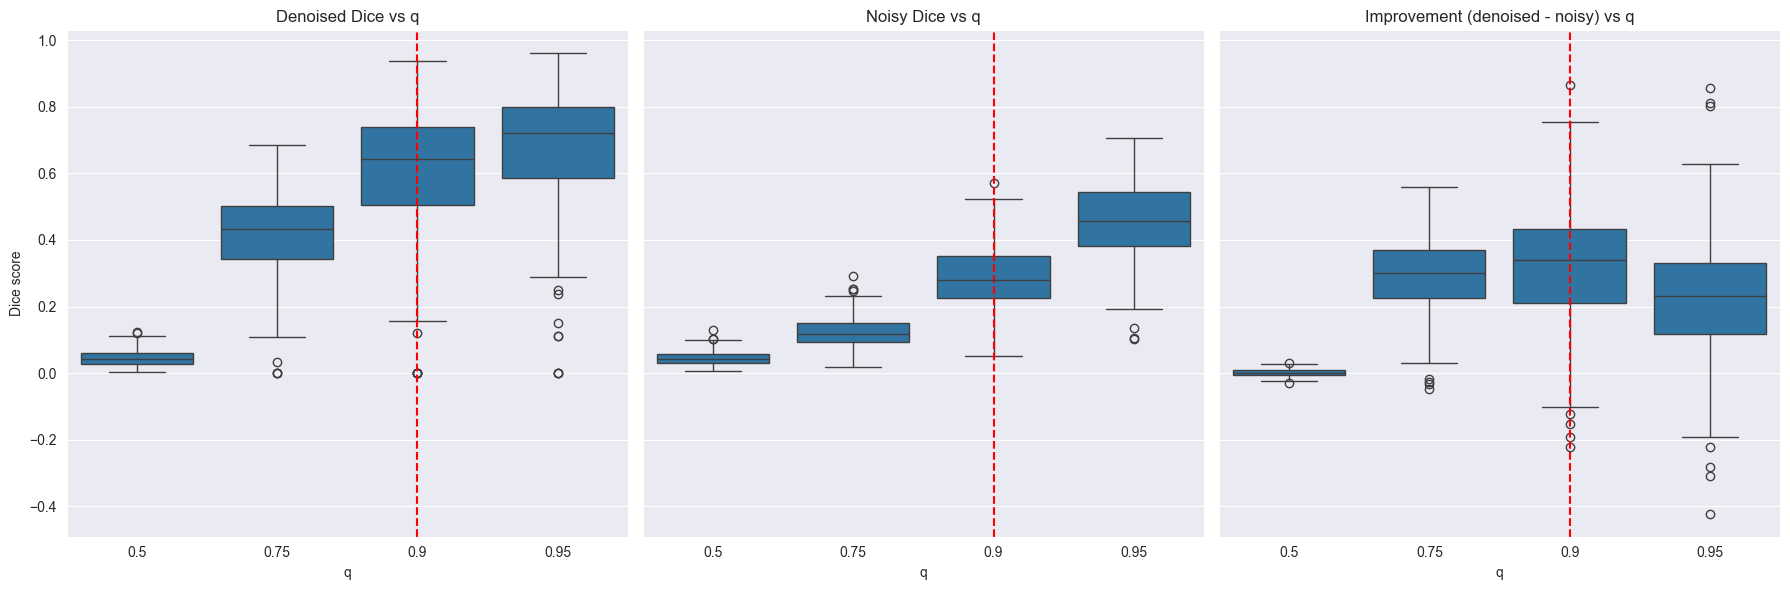

In [18]:
plot_dice_boxplots(df_results)

## Big noisiness parameter in the chain

In [19]:
import numpy as np
import pandas as pd
from tqdm import tqdm

results = []

for idx in tqdm(selected_indices, desc="Processing images"):
    image, info = load_image(idx)
    magnetized = magnetize_image(np.array(image))

    for q in q_values:
        noisy = add_flip_noise(magnetized, q=q, show=False)
        denoised = ising.IsingDeNoise(noisy, 0.75)
        denoised[denoised >= 0] = 1
        denoised[denoised < 0] = -1

        dice_denoised = dice_score(denoised, magnetized)
        dice_noisy = dice_score(noisy, magnetized)

        results.append({
            "image_value": info["value"],
            "image_character": info["character"],
            "suite_id": info['suite_id'],
            "sample_id": info['sample_id'],
            "code": info['code'],
            "q": q,
            "denoised_dice": dice_denoised,
            "noise_dice": dice_noisy
        })

df_results = pd.DataFrame(results)


Processing images: 100%|██████████| 200/200 [30:51<00:00,  9.26s/it]


In [20]:
df_results.to_csv("ising_denoising_results_small_q.csv", index=False)

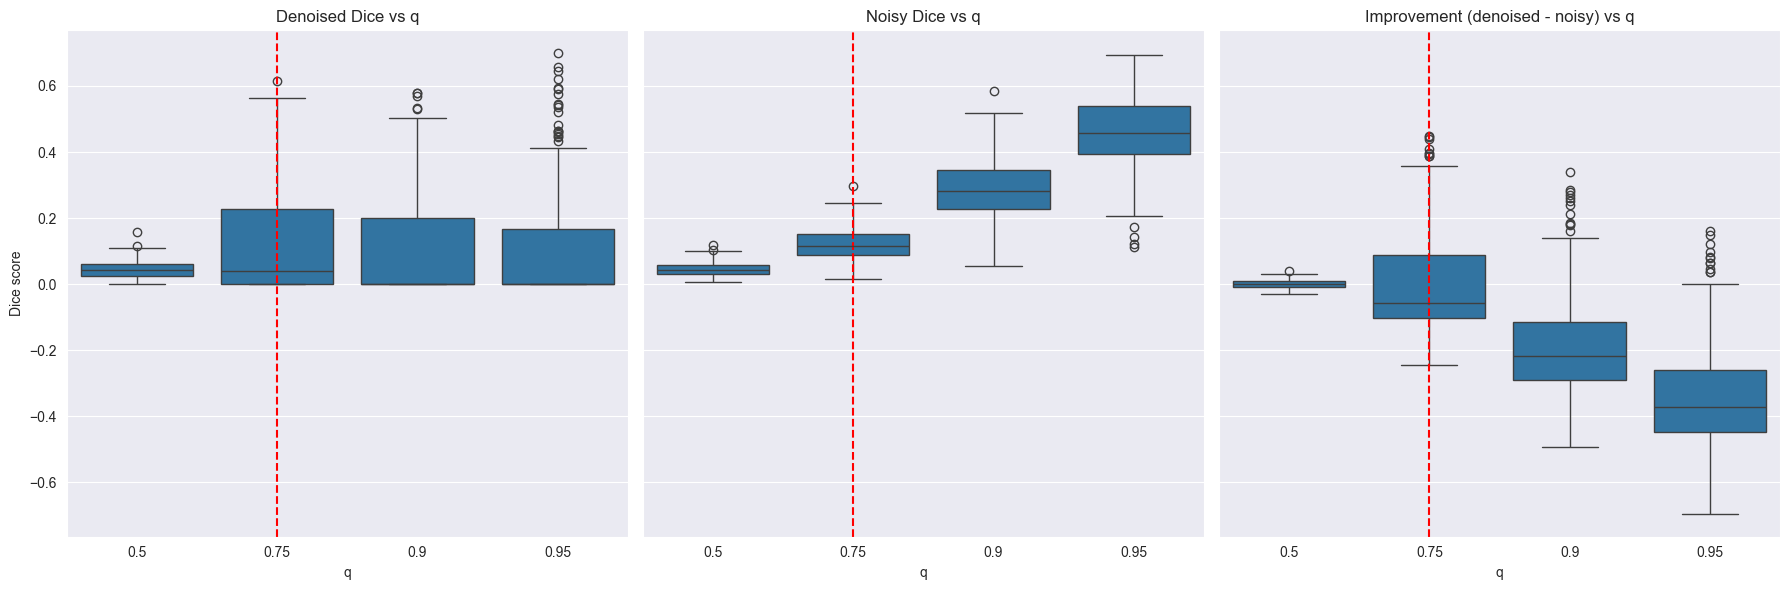

In [21]:
plot_dice_boxplots(df_results, highlight_q=0.75)

# Testing

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro

def test_distribution(df, column="denoised_dice", alpha=0.05, plot=True):
    results = []
    for q_val in sorted(df["q"].unique()):
        subset = df[df["q"] == q_val][column]
        stat, p_value = shapiro(subset)
        normality = p_value > alpha
        results.append({
            "q": q_val,
            "statistic": stat,
            "p_value": p_value,
            "normality": normality
        })

    res_df = pd.DataFrame(results)

    if plot:
        plt.figure(figsize=(8,5))
        sns.barplot(data=res_df, x="q", y="p_value", color="steelblue")

        plt.axhline(alpha, color="red", linestyle="--", label=f"Poziom istotności ({alpha})")

        for i, row in res_df.iterrows():
            if not row["normality"]:
                plt.gca().patches[i].set_alpha(0.4)

        plt.title(f"Test Shapiro-Wilka dla kolumny '{column}'")
        plt.ylabel("p-value")
        plt.xlabel("q")
        plt.legend()
        plt.tight_layout()
        plt.show()

    return res_df

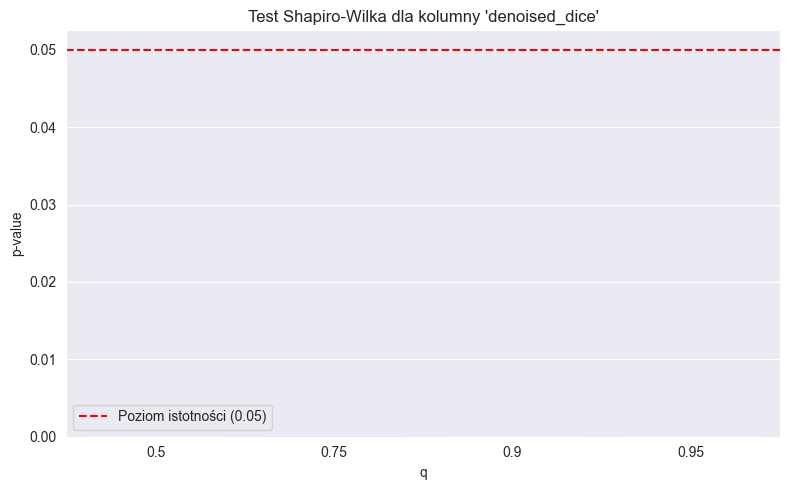

,q,statistic,p_value,normality
0,0.50,0.960058,2.006594e-05,False
1,0.75,0.964543,6.338930e-05,False
2,0.90,0.925513,1.507234e-08,False
3,0.95,0.897316,1.701102e-10,False


In [23]:
df_1 = pd.read_csv("ising_denoising_results.csv")
test_distribution(df_1)

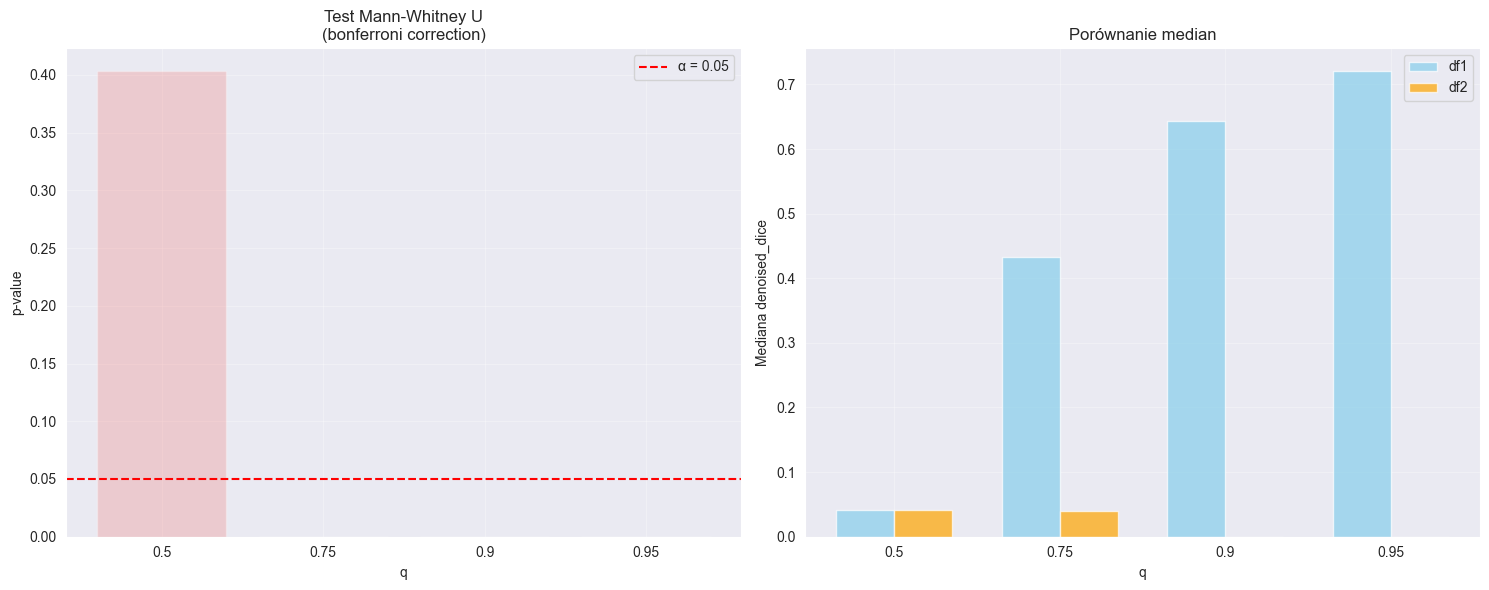


Podsumowanie:
Liczba porównań: 4
Istotnie wyższe w df1: 3/4
Przed korekcją: 3/4
Po korekcie bonferroni: 3/4
      q   n1   n2   median1   median2  statistic       p_value    p_adjusted  \
0  0.50  200  200  0.041046  0.042001    20284.0  4.031462e-01  1.000000e+00   
1  0.75  200  200  0.433586  0.039038    35535.5  4.160850e-42  1.664340e-41   
2  0.90  200  200  0.643604  0.000000    38323.5  2.602222e-58  1.040889e-57   
3  0.95  200  200  0.720451  0.000000    38673.0  1.227917e-60  4.911669e-60   

   significant  significant_raw  
0        False            False  
1         True             True  
2         True             True  
3         True             True  


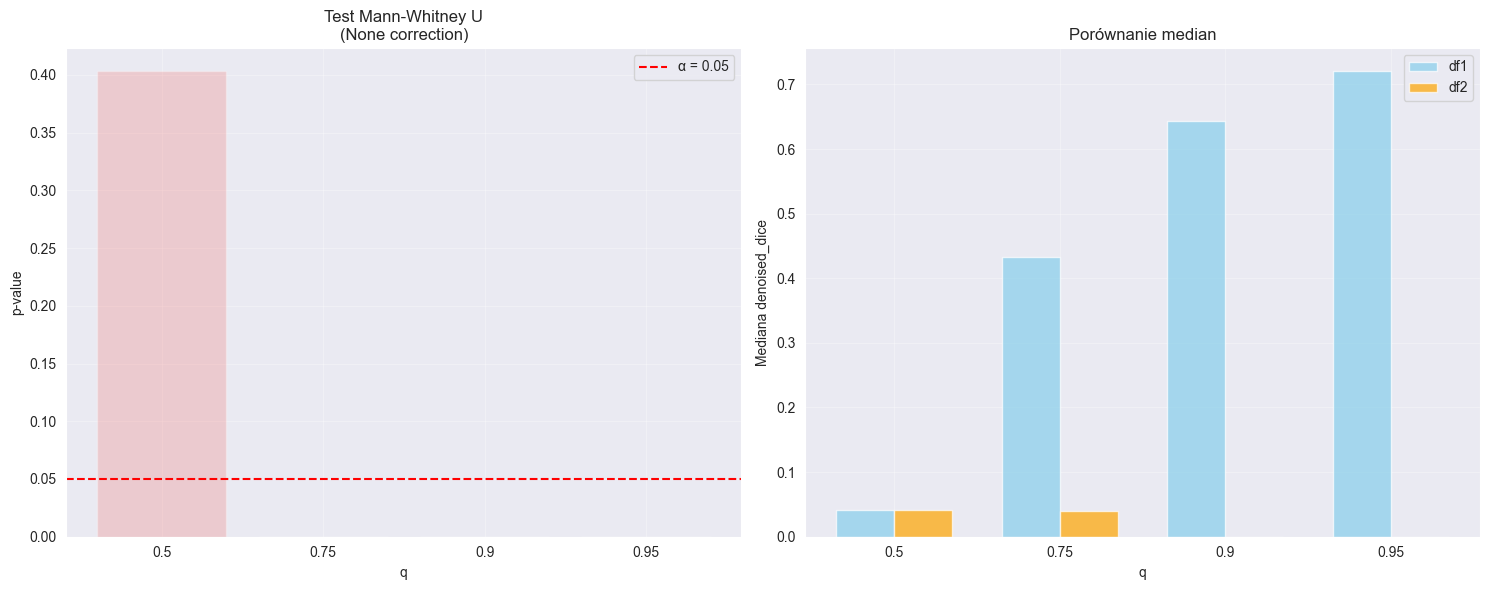


Podsumowanie:
Liczba porównań: 4
Istotnie wyższe w df1: 3/4
      q   n1   n2   median1   median2  statistic       p_value  significant  \
0  0.50  200  200  0.041046  0.042001    20284.0  4.031462e-01        False   
1  0.75  200  200  0.433586  0.039038    35535.5  4.160850e-42         True   
2  0.90  200  200  0.643604  0.000000    38323.5  2.602222e-58         True   
3  0.95  200  200  0.720451  0.000000    38673.0  1.227917e-60         True   

   significant_raw  
0            False  
1             True  
2             True  
3             True  


In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

def mann_whitney_compare(df1, df2, column="denoised_dice", alpha=0.05,
                        correction_method='bonferroni', plot=True):
    results = []
    q_values = sorted(set(df1["q"]).intersection(df2["q"]))

    for q_val in q_values:
        group1 = df1[df1["q"] == q_val][column].dropna()
        group2 = df2[df2["q"] == q_val][column].dropna()

        if len(group1) == 0 or len(group2) == 0:
            continue

        stat, p_value = mannwhitneyu(group1, group2, alternative="greater")

        results.append({
            "q": q_val,
            "n1": len(group1),
            "n2": len(group2),
            "median1": group1.median(),
            "median2": group2.median(),
            "statistic": stat,
            "p_value": p_value
        })

    res_df = pd.DataFrame(results)

    if len(res_df) == 0:
        print("Brak danych do porównania!")
        return res_df

    if correction_method:
        rejected, p_adjusted, _, _ = multipletests(
            res_df['p_value'], alpha=alpha, method=correction_method
        )
        res_df['p_adjusted'] = p_adjusted
        res_df['significant'] = rejected
        res_df['significant_raw'] = res_df['p_value'] < alpha
    else:
        res_df['significant'] = res_df['p_value'] < alpha
        res_df['significant_raw'] = res_df['significant']

    if plot:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        colors = ['mediumseagreen' if sig else 'lightcoral'
                 for sig in res_df['significant']]

        bars = ax1.bar(range(len(res_df)), res_df['p_value'], color=colors, alpha=0.7)

        for i, (bar, sig) in enumerate(zip(bars, res_df['significant'])):
            if not sig:
                bar.set_alpha(0.3)

        ax1.axhline(alpha, color="red", linestyle="--",
                   label=f"α = {alpha}")
        ax1.set_xlabel("q")
        ax1.set_ylabel("p-value")
        ax1.set_title(f"Test Mann-Whitney U\n({correction_method} correction)")
        ax1.set_xticks(range(len(res_df)))
        ax1.set_xticklabels(res_df['q'])
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        x_pos = np.arange(len(res_df))
        width = 0.35

        ax2.bar(x_pos - width/2, res_df['median1'], width,
               label='df1', alpha=0.7, color='skyblue')
        ax2.bar(x_pos + width/2, res_df['median2'], width,
               label='df2', alpha=0.7, color='orange')

        ax2.set_xlabel("q")
        ax2.set_ylabel(f"Mediana {column}")
        ax2.set_title("Porównanie median")
        ax2.set_xticks(x_pos)
        ax2.set_xticklabels(res_df['q'])
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    n_significant = res_df['significant'].sum()
    n_total = len(res_df)

    print(f"\nPodsumowanie:")
    print(f"Liczba porównań: {n_total}")
    print(f"Istotnie wyższe w df1: {n_significant}/{n_total}")

    if correction_method:
        n_raw_sig = res_df['significant_raw'].sum()
        print(f"Przed korekcją: {n_raw_sig}/{n_total}")
        print(f"Po korekcie {correction_method}: {n_significant}/{n_total}")

    return res_df

df1 = pd.read_csv("ising_denoising_results.csv")
df2 = pd.read_csv("ising_denoising_results_small_q.csv")

test_results = mann_whitney_compare(df1, df2, column="denoised_dice", alpha=0.05, plot=True)
print(test_results)
test_results = mann_whitney_compare(df1, df2, correction_method=None, column="denoised_dice", alpha=0.05, plot=True)
print(test_results)


# Character vs DICE

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_dice_vs_character_boxplots(df, q = 0.9):
    df = df.copy()
    df = df[df["q"] == q]
    df["improvement"] = df["denoised_dice"] - df["noise_dice"]

    fig, axes = plt.subplots(1, 3, figsize=(25, 6), sharey=True)

    sns.boxplot(data=df, x="image_value", y="denoised_dice", ax=axes[0])
    axes[0].set_title("Denoised Dice vs q")
    axes[0].set_xlabel("character")
    axes[0].set_ylabel("Dice score")

    sns.boxplot(data=df, x="image_value", y="noise_dice", ax=axes[1])
    axes[1].set_title("Noisy Dice vs q")
    axes[1].set_xlabel("character")
    axes[1].set_ylabel("")

    sns.boxplot(data=df, x="image_value", y="improvement", ax=axes[2])
    axes[2].set_title("Improvement (denoised - noisy) vs q")
    axes[2].set_xlabel("character")
    axes[2].set_ylabel("")

    plt.tight_layout()
    plt.show()

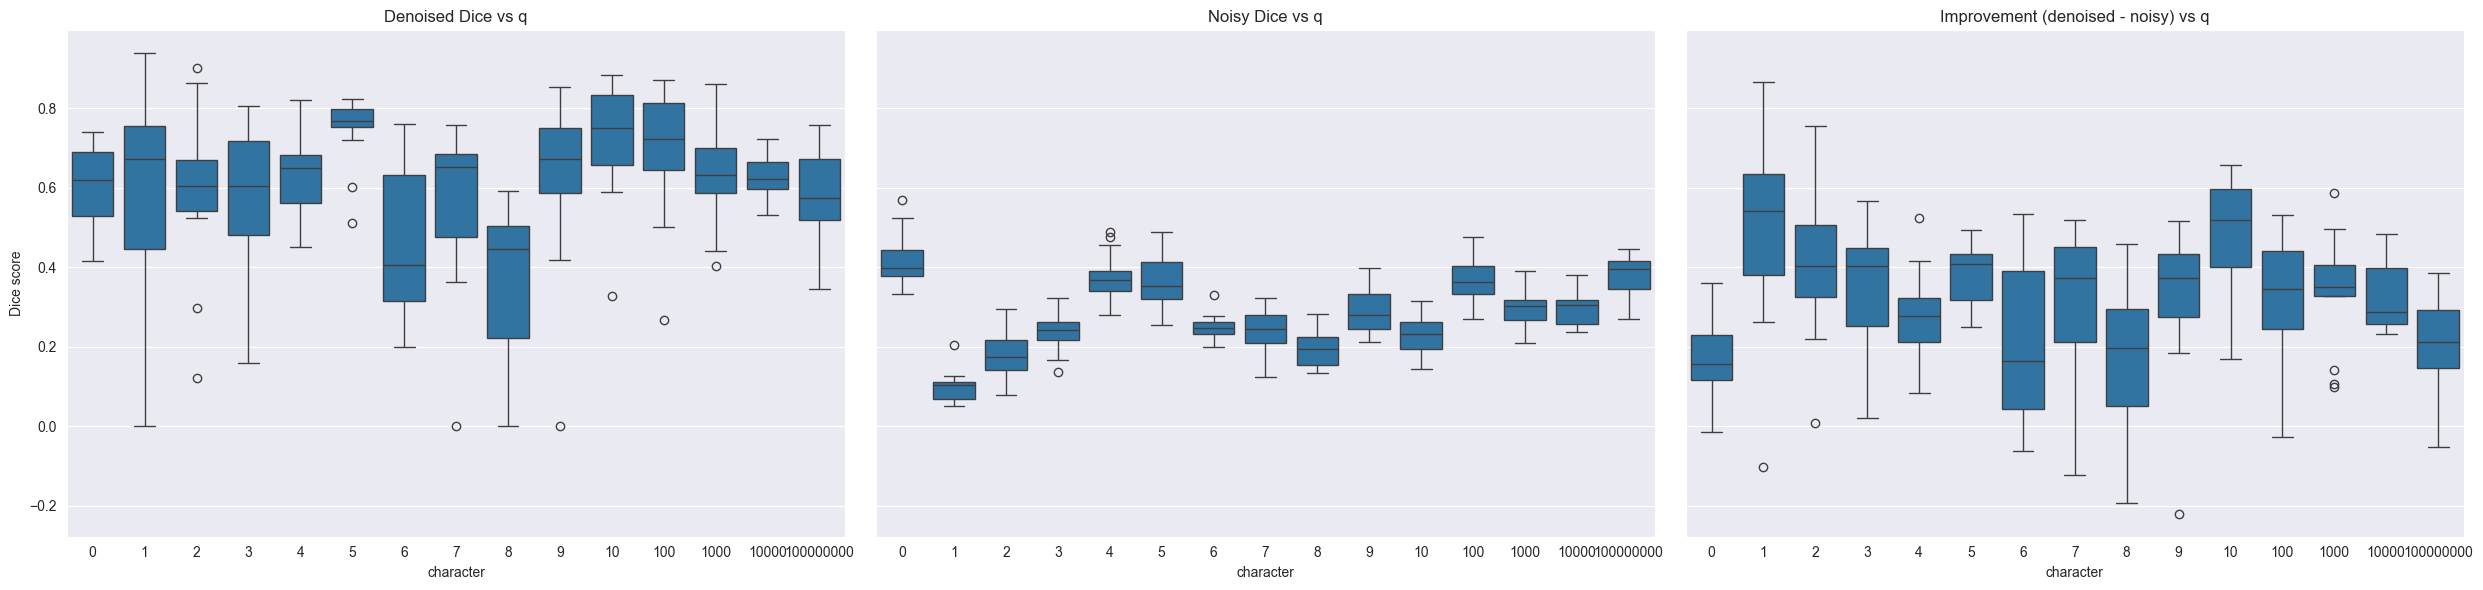

In [26]:
plot_dice_vs_character_boxplots(df1)

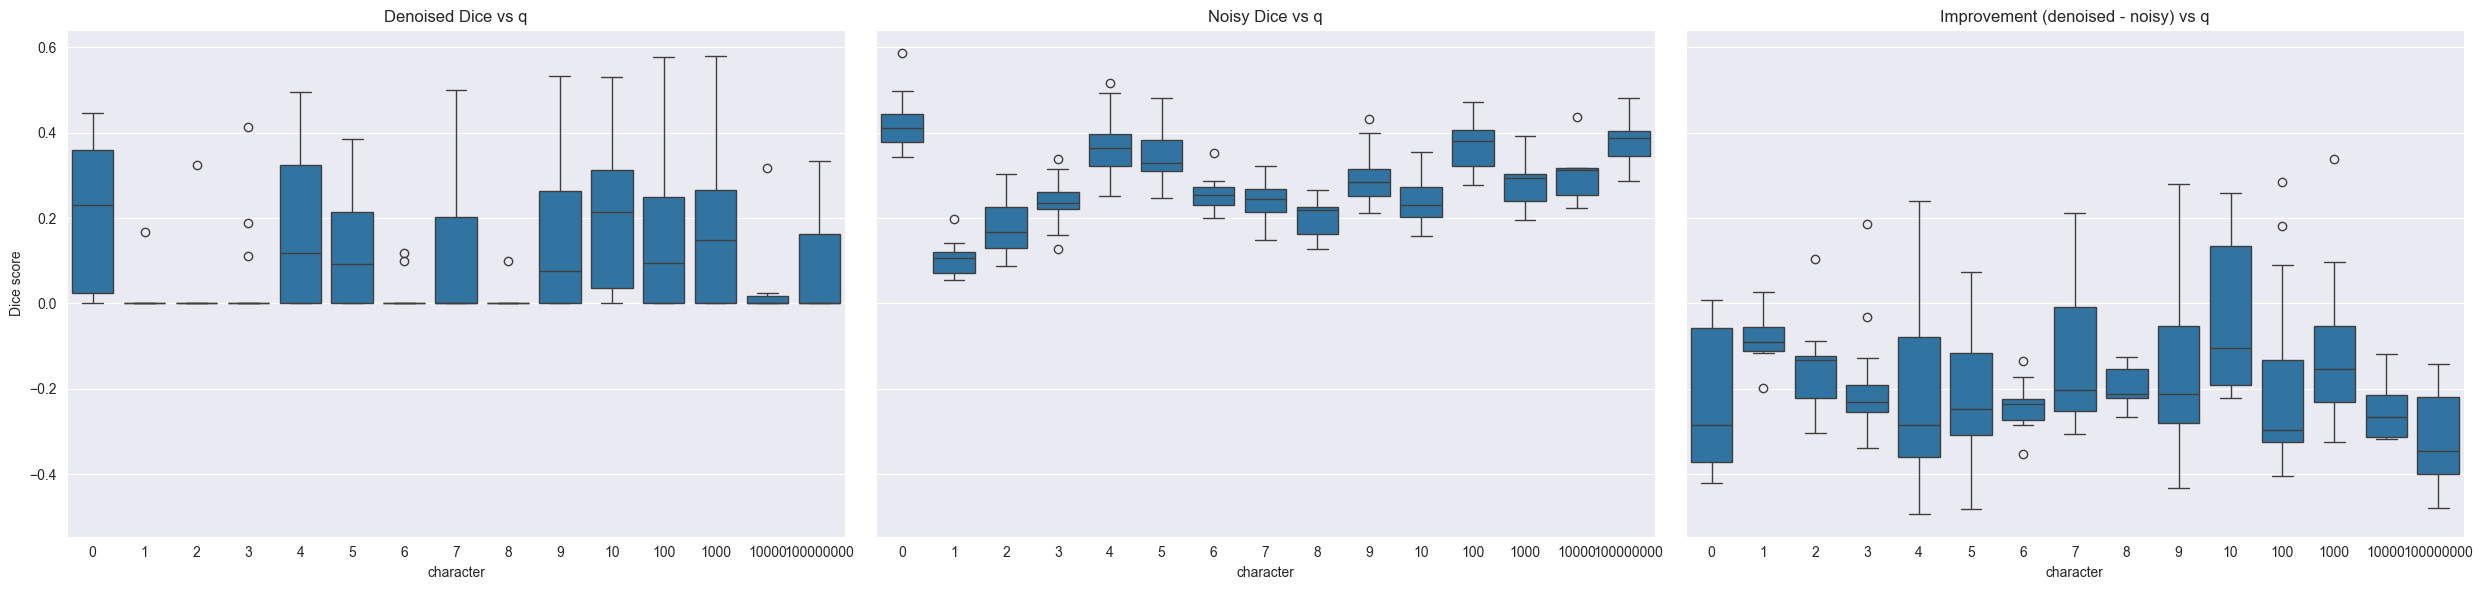

In [27]:
plot_dice_vs_character_boxplots(df2)

In [28]:
df1["image_value"].value_counts().sort_index()

image_value
0            40
1            32
2            44
3            88
4            52
5            52
6            52
7            60
8            44
9            76
10           48
100          80
1000         52
10000        24
100000000    56
Name: count, dtype: int64

Why improvement in 0 is so bad?

In [29]:
def get_image_index(suite_id, sample_id, code, csv_path="archive/chinese_mnist.csv"):
    df = pd.read_csv(csv_path)

    matching_rows = df[
        (df['suite_id'] == suite_id) &
        (df['sample_id'] == sample_id) &
        (df['code'] == code)
    ]

    if len(matching_rows) == 0:
        raise ValueError(f"Nie znaleziono wiersza dla suite_id={suite_id}, sample_id={sample_id}, code={code}")
    elif len(matching_rows) > 1:
        raise ValueError(f"Znaleziono więcej niż jeden wiersz dla suite_id={suite_id}, sample_id={sample_id}, code={code}")

    return matching_rows.index[0]

In [30]:
value_0_indices = df1.loc[df1["image_value"] == 0, ["suite_id", "sample_id", "code"]]

In [31]:
value_0_indices

,suite_id,sample_id,code
60,44,6,1
61,44,6,1
62,44,6,1
63,44,6,1
176,21,1,1
177,21,1,1
178,21,1,1
179,21,1,1
316,38,6,1
317,38,6,1


Znak chiński: 零 Values: (np.float64(-1.0), np.float64(1.0))


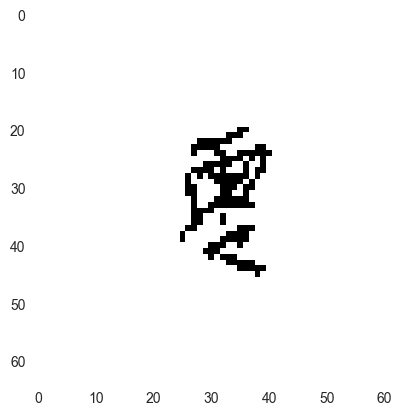

In [32]:
example = value_0_indices.iloc[0]
img, meta = load_image(get_image_index(example["suite_id"], example["sample_id"], example["code"]))
magnetized_img = magnetize_image(np.array(img))
print("Znak chiński:", meta["character"], "Values:", (magnetized_img.min(), magnetized_img.max()))
plt.imshow(magnetized_img, cmap="gray")
plt.grid(False)

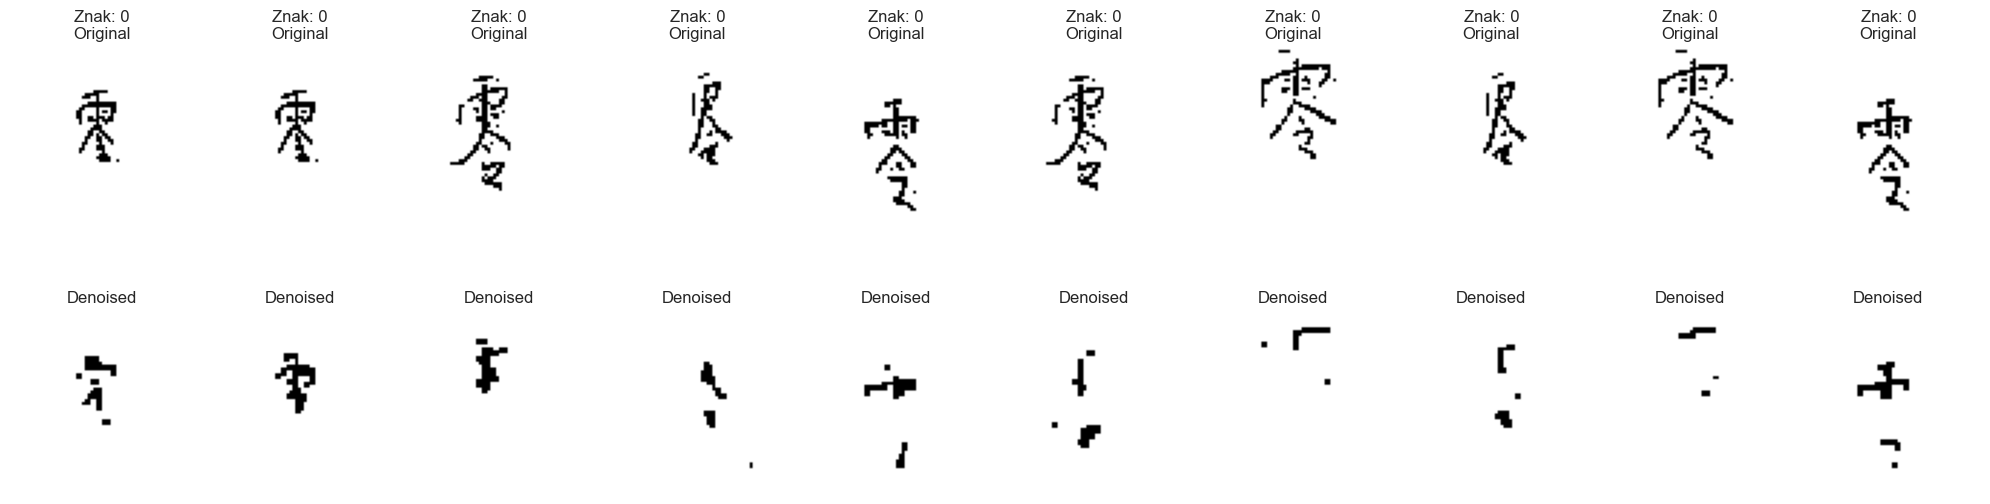

In [33]:
random_samples = value_0_indices.sample(n=10, random_state=42)

# Utwórz subplot 2x10 (2 wiersze, 10 kolumn) - górny wiersz oryginały, dolny denoised
fig, axes = plt.subplots(2, 10, figsize=(20, 6))

for i, (_, example) in enumerate(random_samples.iterrows()):
    img, meta = load_image(get_image_index(example["suite_id"], example["sample_id"], example["code"]))
    magnetized_img = magnetize_image(np.array(img))
    noisy = add_flip_noise(magnetized_img, q=0.9, show=False)
    denoised = ising.IsingDeNoise(noisy, 0.9)
    denoised[denoised >= 0] = 1
    denoised[denoised < 0] = -1

    axes[0, i].imshow(magnetized_img, cmap="gray")
    axes[0, i].set_title(f"Znak: {meta['value']}\nOriginal")
    axes[0, i].grid(False)
    axes[0, i].axis('off')

    axes[1, i].imshow(denoised, cmap="gray")
    axes[1, i].set_title(f"Denoised")
    axes[1, i].grid(False)
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

Why improvement in 1 is so good?

In [34]:
value_1_indices = df1.loc[df1["image_value"] == 1, ["suite_id", "sample_id", "code"]]

In [35]:
value_1_indices

,suite_id,sample_id,code
140,98,2,2
141,98,2,2
142,98,2,2
143,98,2,2
264,65,4,2
265,65,4,2
266,65,4,2
267,65,4,2
296,25,3,2
297,25,3,2


Znak chiński: 一 Values: (np.float64(-1.0), np.float64(1.0))


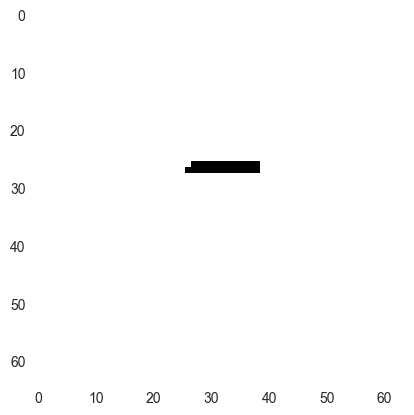

In [36]:
example = value_1_indices.iloc[0]
img, meta = load_image(get_image_index(example["suite_id"], example["sample_id"], example["code"]))
magnetized_img = magnetize_image(np.array(img))
print("Znak chiński:", meta["character"], "Values:", (magnetized_img.min(), magnetized_img.max()))
plt.imshow(magnetized_img, cmap="gray")
plt.grid(False)

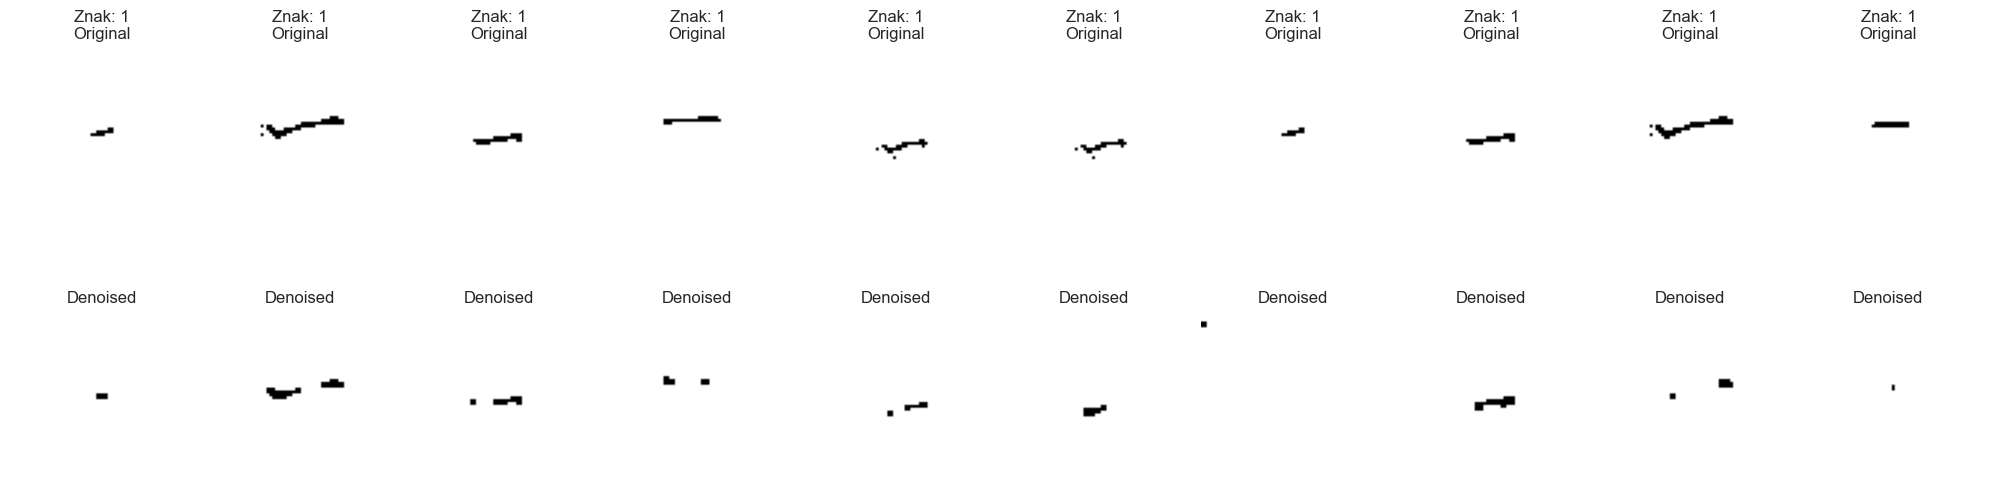

In [37]:
random_samples = value_1_indices.sample(n=10, random_state=42)

fig, axes = plt.subplots(2, 10, figsize=(20, 6))

for i, (_, example) in enumerate(random_samples.iterrows()):
    # Załaduj obraz i metadane
    img, meta = load_image(get_image_index(example["suite_id"], example["sample_id"], example["code"]))
    magnetized_img = magnetize_image(np.array(img))
    noisy = add_flip_noise(magnetized_img, q=0.9, show=False)
    denoised = ising.IsingDeNoise(noisy, 0.9)
    denoised[denoised >= 0] = 1
    denoised[denoised < 0] = -1

    # Wyplotuj oryginalny obraz (górny wiersz)
    axes[0, i].imshow(magnetized_img, cmap="gray")
    axes[0, i].set_title(f"Znak: {meta['value']}\nOriginal")
    axes[0, i].grid(False)
    axes[0, i].axis('off')

    # Wyplotuj denoised obraz (dolny wiersz)
    axes[1, i].imshow(denoised, cmap="gray")
    axes[1, i].set_title(f"Denoised")
    axes[1, i].grid(False)
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

In [38]:
np.array(img).shape

(64, 64)

# New neighbourhood

In [39]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import ising2
importlib.reload(ising2)

results = []

for idx in tqdm(selected_indices, desc="Processing images"):
    image, info = load_image(idx)
    magnetized = magnetize_image(np.array(image))

    for q in q_values:
        noisy = add_flip_noise(magnetized, q=q, show=False)
        denoised = ising2.IsingDeNoise(noisy, 0.9)
        denoised[denoised >= 0] = 1
        denoised[denoised < 0] = -1

        dice_denoised = dice_score(denoised, magnetized)
        dice_noisy = dice_score(noisy, magnetized)

        results.append({
            "image_value": info["value"],
            "image_character": info["character"],
            "suite_id": info['suite_id'],
            "sample_id": info['sample_id'],
            "code": info['code'],
            "q": q,
            "denoised_dice": dice_denoised,
            "noise_dice": dice_noisy
        })

df_results = pd.DataFrame(results)


Processing images: 100%|██████████| 200/200 [39:07<00:00, 11.74s/it]


In [40]:
df_results.to_csv("ising_denoising_results_new_neighbourhood2.csv", index=False)

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_dice_comparison_boxplot(
    df1, df2,
    group_col="q",
    value_col="denoised_dice",
    label1="Model 1",
    label2="Model 2"
):
    df1 = df1.copy()
    df2 = df2.copy()

    df1["source"] = label1
    df2["source"] = label2

    combined_df = pd.concat([df1, df2], ignore_index=True)

    plt.figure(figsize=(12, 6))
    sns.boxplot(data=combined_df, x=group_col, y=value_col, hue="source")
    plt.title(f"Comparison of '{value_col}' grouped by '{group_col}'")
    plt.xlabel(group_col)
    plt.ylabel(value_col)
    plt.legend(title="Data source")
    plt.tight_layout()
    plt.show()


In [43]:
df1 = pd.read_csv("ising_denoising_results_new_neighbourhood2.csv")
df2 = pd.read_csv("ising_denoising_results.csv")

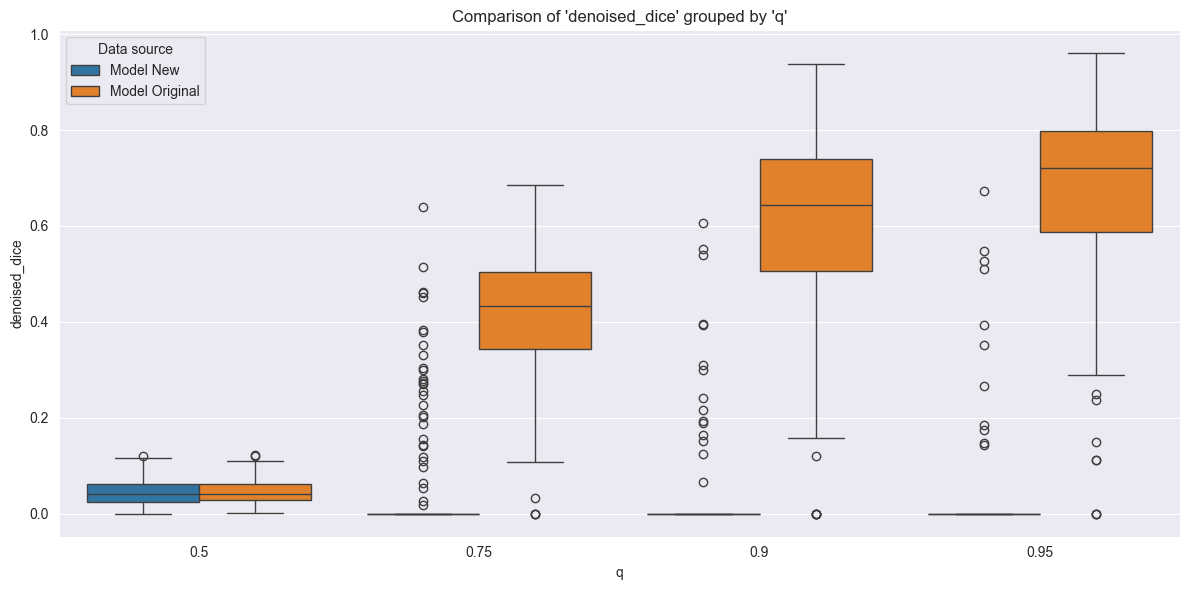

In [44]:
plot_dice_comparison_boxplot(df1, df2, group_col="q", value_col="denoised_dice", label1="Model New", label2="Model Original")

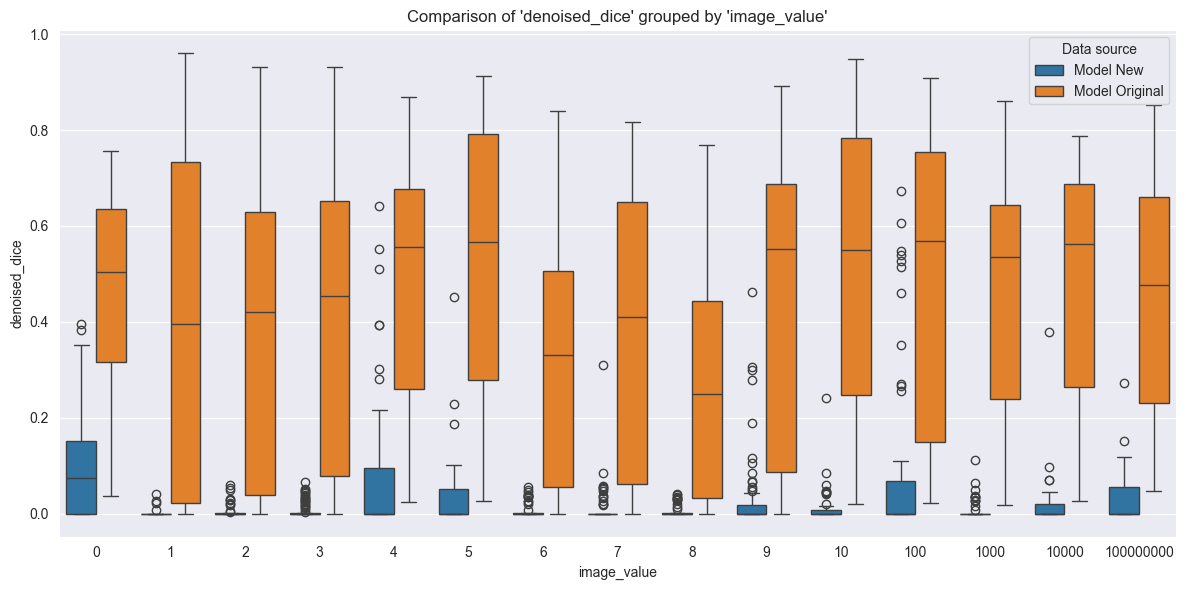

In [45]:
plot_dice_comparison_boxplot(df1, df2, group_col="image_value", value_col="denoised_dice", label1="Model New", label2="Model Original")

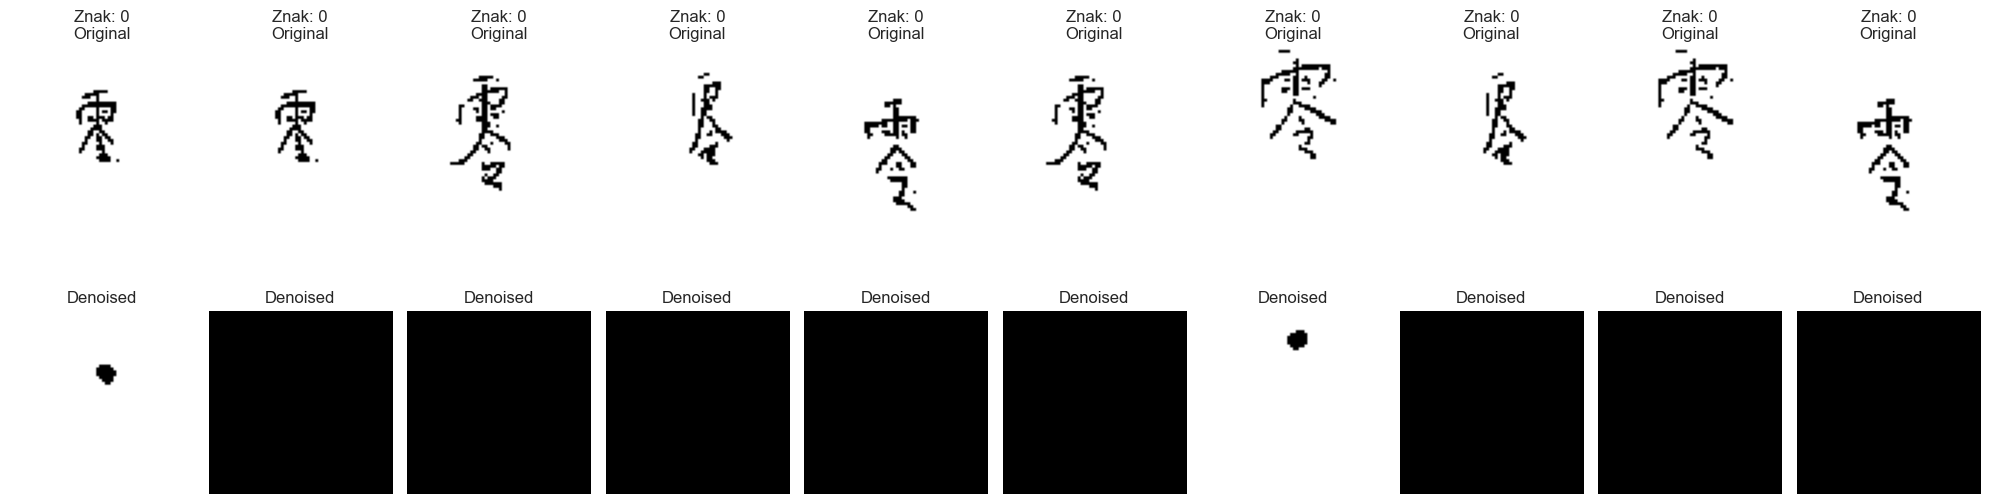

In [46]:
value_1_indices = df1.loc[df1["image_value"] == 1, ["suite_id", "sample_id", "code"]]
random_samples = value_0_indices.sample(n=10, random_state=42)

fig, axes = plt.subplots(2, 10, figsize=(20, 6))

for i, (_, example) in enumerate(random_samples.iterrows()):
    img, meta = load_image(get_image_index(example["suite_id"], example["sample_id"], example["code"]))
    magnetized_img = magnetize_image(np.array(img))
    noisy = add_flip_noise(magnetized_img, q=0.9, show=False)
    denoised = ising2.IsingDeNoise(noisy, 0.9)
    denoised[denoised >= 0] = 1
    denoised[denoised < 0] = -1

    axes[0, i].imshow(magnetized_img, cmap="gray")
    axes[0, i].set_title(f"Znak: {meta['value']}\nOriginal")
    axes[0, i].grid(False)
    axes[0, i].axis('off')

    axes[1, i].imshow(denoised, cmap="gray")
    axes[1, i].set_title(f"Denoised")
    axes[1, i].grid(False)
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()


# Clumpiness

In [48]:
def compute_clumpiness(Z):
    h, w = Z.shape
    total = 0
    count = 0

    for dx, dy in [(-1,0), (1,0), (0,-1), (0,1)]:  # 4 neighbors
        shifted = np.roll(Z, shift=(dx, dy), axis=(0, 1))
        agreement = (Z * shifted + 1) / 2  # 1 if same, 0 if different
        total += agreement.sum()
        count += h * w

    return total / count


def calculate_f1_score(original, cleaned):
    true_positive = np.sum((original == 1) & (cleaned == 1))
    false_positive = np.sum((original == -1) & (cleaned == 1))
    false_negative = np.sum((original == 1) & (cleaned == -1))

    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0

    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return f1_score

def calculate_accuracy(original, cleaned):
    correct_predictions = np.sum(original == cleaned)
    total_predictions = original.size
    return correct_predictions / total_predictions


def create_noisy_image(Z, q=0.9):
    noise = np.random.random(size = Z.size).reshape(Z.shape) > q
    noisy = np.array(Z)
    noisy[noise] = -noisy[noise]
    return noisy


def dice_score(pred: np.ndarray, target: np.ndarray) -> float:
    pred = pred.flatten()
    target = target.flatten()

    # Zamień -1 → 1, 1 → 0
    pred = (pred == -1).astype(np.uint8)
    target = (target == -1).astype(np.uint8)

    intersection = np.sum(pred & target)
    total = np.sum(pred) + np.sum(target)

    if total == 0:
        return 1.0  # Obie maski puste

    return 2.0 * intersection / total

In [88]:
csv_path = "archive/chinese_mnist.csv"
df_csv = pd.read_csv(csv_path)
total_images = len(df_csv)

num_images = 200
selected_indices = np.random.choice(total_images, size=num_images, replace=False)

In [49]:
accuracies = []
f1_scores = []
clumpiness = []
for idx in tqdm(selected_indices, desc="Processing images"):
    image, info = load_image(idx)
    magnetized = magnetize_image(np.array(image))

    noisy = add_flip_noise(magnetized, q=q, show=False)
    denoised = ising.IsingDeNoise(noisy, 0.9)
    denoised[denoised >= 0] = 1
    denoised[denoised < 0] = -1

    accuracy = calculate_accuracy(magnetized, denoised)
    f1_score = calculate_f1_score(magnetized, denoised)

    clumpiness.append(compute_clumpiness(magnetized))
    accuracies.append(accuracy)
    f1_scores.append(f1_score)


Processing images: 100%|██████████| 200/200 [07:29<00:00,  2.25s/it]


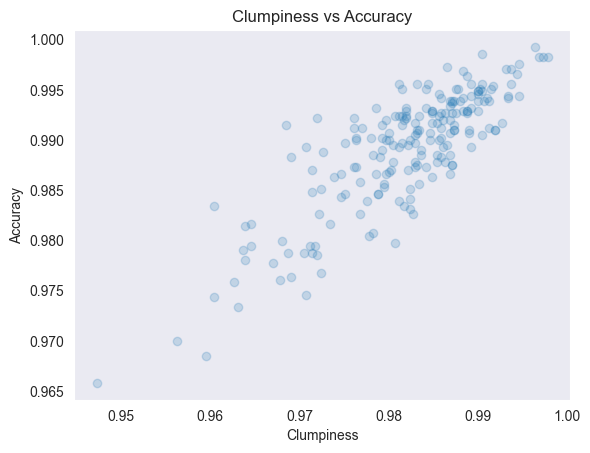

In [50]:
plt.scatter(clumpiness, accuracies, alpha=0.2)
plt.xlabel('Clumpiness')
plt.ylabel('Accuracy')
plt.title('Clumpiness vs Accuracy')
plt.grid()
plt.show()

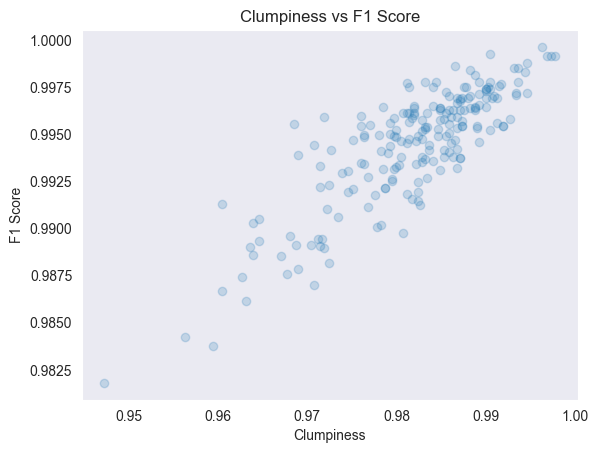

In [51]:
plt.scatter(clumpiness, f1_scores, alpha=0.2)
plt.title('Clumpiness vs F1 Score')
plt.xlabel('Clumpiness')
plt.ylabel('F1 Score')
plt.grid()
plt.show()

In [52]:
accuracies = []
f1_scores = []
clumpiness = []
for idx in tqdm(selected_indices, desc="Processing images"):
    image, info = load_image(idx)
    magnetized = magnetize_image(np.array(image))

    noisy = add_flip_noise(magnetized, q=q, show=False)
    denoised = ising2.IsingDeNoise(noisy, 0.9)
    denoised[denoised >= 0] = 1
    denoised[denoised < 0] = -1

    accuracy = calculate_accuracy(magnetized, denoised)
    f1_score = calculate_f1_score(magnetized, denoised)

    clumpiness.append(compute_clumpiness(magnetized))
    accuracies.append(accuracy)
    f1_scores.append(f1_score)


Processing images:  42%|████▎     | 85/200 [04:11<05:39,  2.95s/it]


KeyboardInterrupt: 

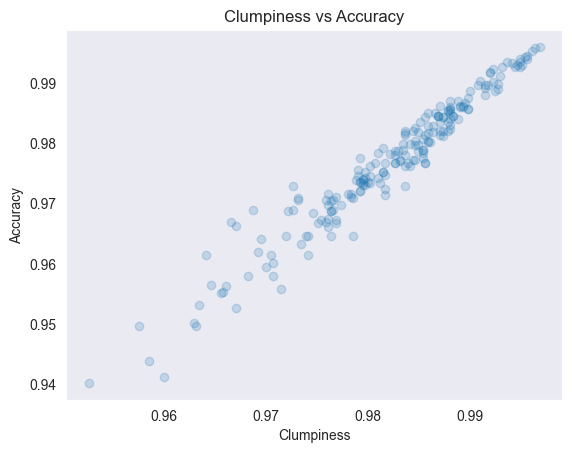

In [93]:
plt.scatter(clumpiness, accuracies, alpha=0.2)
plt.xlabel('Clumpiness')
plt.ylabel('Accuracy')
plt.title('Clumpiness vs Accuracy')
plt.grid()
plt.show()

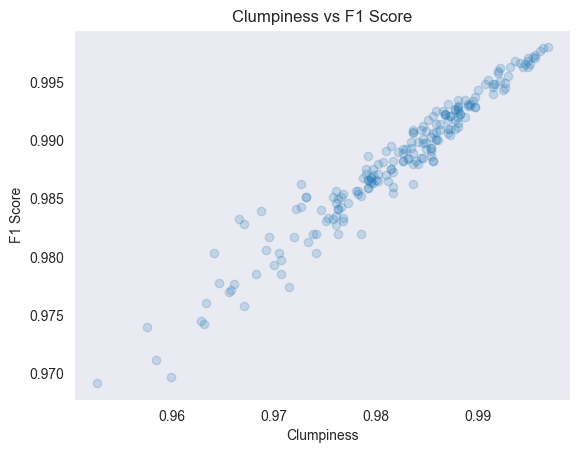

In [94]:
plt.scatter(clumpiness, f1_scores, alpha=0.2)
plt.title('Clumpiness vs F1 Score')
plt.xlabel('Clumpiness')
plt.ylabel('F1 Score')
plt.grid()
plt.show()